In [69]:
import pandas as pd
import numpy as np
import re

In [7]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
ls

[투자전략팀] 현존 외투기업 연도별 신고도착금액 (2010-2022) (16000여개사).xlsx
(230105) AI 투자유망지수 개발 Dataset_v.3.xlsx
invest_corr.csv
Invest.ipynb
Invest_Prediction.csv
invest_re.ipynb
XGB_VAR_IMP.csv


In [4]:
pd.set_option('display.max_columns', None)

In [108]:
def make_data():
    data = pd.read_excel('(230105) AI 투자유망지수 개발 Dataset_v.3.xlsx', engine = 'openpyxl', dtype = {'사업자등록번호':str, '세분류명(4계층)':str})
    full_data = pd.read_excel('[투자전략팀] 현존 외투기업 연도별 신고도착금액 (2010-2022) (16000여개사).xlsx', dtype = {'사업자번호':str}, engine = 'openpyxl')
    temp_data = full_data.filter(regex = '2010|2011|2012|2013|2014|2015|2016|사업자')
    temp_data.rename(columns = {'사업자번호':'사업자등록번호'}, inplace = True)
    data = data.merge(temp_data, how = 'left')
    
    return data
    

In [109]:
data = make_data()

In [110]:
data.head(1)

,업체코드,업체명,국가,투자자명,표준산업\n분류코드,대표업종,세분류명(4계층),사업자등록번호,종업원 수,매출액(2017),매출액(2018),매출액(2019),매출액(2020),매출액(2021),영업이익(2017),영업이익(2018),영업이익(2019),영업이익(2020),영업이익(2021),미처분이익잉여금(2017),미처분이익잉여금(2018),미처분이익잉여금(2019),미처분이익잉여금(2020),미처분이익잉여금(2021),매출액증가율(2017),매출액증가율(2018),매출액증가율(2019),매출액증가율(2020),매출액증가율(2021),매출액영업이익율(2017),매출액영업이익율(2018),매출액영업이익율(2019),매출액영업이익율(2020),매출액영업이익율(2021),수출액(2017),수출액(2018),수출액(2019),수출액(2020),수출액(2021),수출액(2022),투자신고금액(2017),투자신고금액(2018),투자신고금액(2019),투자신고금액(2020),투자신고금액(2021),투자신고금액(2022),투자도착금액(2017),투자도착금액(2018),투자도착금액(2019),투자도착금액(2020),투자도착금액(2021),투자도착금액(2022),투자신고금액(2010),투자신고금액(2011),투자신고금액(2012),투자신고금액(2013),투자신고금액(2014),투자신고금액(2015),투자신고금액(2016),투자도착금액(2010),투자도착금액(2011),투자도착금액(2012),투자도착금액(2013),투자도착금액(2014),투자도착금액(2015),투자도착금액(2016)
0,K0007017,신무림제지주식회사,IFC,INTERNATIONAL FINANCE CORP.외 1명,제지・목재,"펄프,종이 및 종이제품 제조업",17122,6138100289,423.0,452156896.0,482776100.0,495818141.0,404975197.0,456065042.0,14384859.0,2378110.0,10821950.0,8308082.0,-18404330.0,127248658.0,118637754.0,113348363.0,115775586.0,96738853.0,-5.29,6.77,2.7,-18.32,12.62,3.18,0.49,2.18,2.05,-4.04,173463821.0,211861827.0,223324038.0,157055353.0,161226513.0,169448825.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
len(data.columns) -11

55

In [149]:
313/5695  # 0.055

0.05496049165935031

In [111]:
# data.columns  # 산업, 대표업종, 세분류명(4계층) 을 어떻게 전처리 할 것인지??
print(len(data['표준산업\n분류코드'].value_counts()))
print(len(data['대표업종'].value_counts()))
print(len(data['세분류명(4계층)'].value_counts()))

28
196
720


In [112]:
def preprocess_for_train(data):
    
    # 학습에 필요한 컬럼 정리
    drop_cols = ['업체코드', '업체명', '투자자명','세분류명(4계층)']
    dropcols_for_train = ['매출액(2021)', '영업이익(2021)', '미처분이익잉여금(2021)', '매출액증가율(2021)', 
                      '매출액영업이익율(2021)', '수출액(2022)', '투자도착금액(2022)']
    
    # dropcols_for_predict = ['매출액(2017)', '영업이익(2017)', '미처분이익잉여금(2017)', '매출액증가율(2017)', 
    #                  '매출액영업이익율(2017)', '수출액(2017)', '투자신고금액(2017)','투자도착금액(2017)']
    
    
    # data['대표업종'] = data['대표업종'].str.replace('기타 교육기관|일반 교습학원','서비스업')
    # data['대표업종'] = data['대표업종'].str.replace('측정, 시험, 항해, 제어 및 기타 정밀기기 제조업; 광학기기 제외','제조업')
    # data['new_대표업종'] = data['대표업종'].apply(lambda x : re.findall('\w+업',x)[0])
    # data = data.drop(['대표업종'], axis=1)
    
    # detail_idx = data['세분류명(4계층)'].value_counts()[data['세분류명(4계층)'].value_counts() > 20].index.tolist()
    # data['세분류명(4계층)'] = data['세분류명(4계층)'].apply(lambda x: x if x in detail_idx else '00000')
    
    
    df = data.drop(drop_cols + dropcols_for_train, axis =1).copy()
    X = df.drop(['투자신고금액(2022)'], axis = 1).set_index('사업자등록번호')
    y = df['투자신고금액(2022)']
    y = y.apply(lambda x: 1 if x >0 else 0)
    X = pd.get_dummies(X)
    
    # 학습용 / 테스트용 데이터 분리
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    
    return X_train, X_test, y_train, y_test
    
    

In [113]:
X_train, X_test, y_train, y_test = preprocess_for_train(data)
print(X_train.shape, X_test.shape)

(3986, 373) (1709, 373)


In [140]:
y_train.value_counts()

0    3756
1     230
Name: 투자신고금액(2022), dtype: int64

In [141]:
y_test.value_counts()

0    1626
1      83
Name: 투자신고금액(2022), dtype: int64

In [114]:
# 평가함수 작성

def eval_func(y_test, y_pred, y_pred_proba):
    # 평가관련 필요함수 호출
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba)
    print(confusion_matrix(y_test, y_pred))
    print('ACC: {0:.4f}, RECALL: {1:.4f}, PRECISION: {2:.4f}, F1: {3:.4f}, ROC: {4:.4f}'.format(acc, rec, pre, f1, roc))

In [115]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [116]:
# xgboost model # 추가하고 싶은 것은?? 전체 데이터 셋에 적용해서 투지여부 데이터 프레임으로 반환하도록 기능 변경

def xgb_clf_model(X_train, X_test, y_train, y_test):
    
    xgb_clf_best = XGBClassifier(scale_pos_weight =20, n_estimators = 1500, 
                             learning_rate = 0.01, max_depth =15, colsample_bylevel =0.7)
    
    xgb_clf_best.fit(X_train, y_train)
    y_pred = xgb_clf_best.predict(X_test)
    y_pred_proba = xgb_clf_best.predict_proba(X_test)
    eval_func(y_test, y_pred, y_pred_proba[:, 1])
        

In [117]:
xgb_clf_model(X_train, X_test, y_train, y_test)

[11:55:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1598   28]
 [  61   22]]
ACC: 0.9479, RECALL: 0.2651, PRECISION: 0.4400, F1: 0.3308, ROC: 0.7363


In [134]:
# light gbm model

def lgbm_clf_model(X_train, X_test, y_train, y_test):
    
    lgbm_clf_best = LGBMClassifier(scale_pos_weight = 20, num_leaves = 100, n_estimators = 1000, learning_rate = 0.01)
    lgbm_clf_best.fit(X_train.values, y_train.values)
    y_pred = lgbm_clf_best.predict(X_test.values)
    y_pred_proba = lgbm_clf_best.predict_proba(X_test.values)
    eval_func(y_test, y_pred, y_pred_proba[:, 1])


In [135]:
lgbm_clf_model(X_train, X_test, y_train, y_test)

[[1608   18]
 [  62   21]]
ACC: 0.9532, RECALL: 0.2530, PRECISION: 0.5385, F1: 0.3443, ROC: 0.7535


In [121]:
# 어떤 함수를 만들지?? 데이터를 넣을 경우 

def preprocess_for_predict(data):
     # 예측에 필요한 컬럼 정리
    drop_cols = ['업체코드', '업체명', '투자자명', '세분류명(4계층)']
    dropcols_for_predict = ['매출액(2017)', '영업이익(2017)', '미처분이익잉여금(2017)', '매출액증가율(2017)', 
                      '매출액영업이익율(2017)', '수출액(2017)', '투자신고금액(2017)','투자도착금액(2017)']
    
    X = data.drop(drop_cols + dropcols_for_predict, axis =1).copy().set_index('사업자등록번호')
    X = pd.get_dummies(X)
    
    return X
    


In [122]:
X = preprocess_for_predict(data)
X.shape

(5695, 373)

In [201]:
X_train.shape

(3986, 373)

In [136]:
lgbm_clf =  LGBMClassifier(scale_pos_weight = 20, num_leaves = 100, n_estimators = 1000, learning_rate = 0.01).fit(X_train.values, y_train.values)


In [125]:
# xgb_clf = XGBClassifier(scale_pos_weight =20, n_estimators = 1500, 
#                              learning_rate = 0.01, max_depth =15, colsample_bylevel =0.7).fit(X_train.values, y_train.values)

[12:03:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [137]:
def make_final_predict(data, clf ='lgbm'):
    
    if clf == 'lgbm':
        clf = lgbm_clf 
        pred = clf.predict(X.values)
        proba = clf.predict_proba(X.values)
        df = pd.DataFrame({'BSNO': X.index.tolist(), 'PRED':pred, 'PROB': proba[:, 1]})
        
    elif clf == 'xgb':
        clf = xgb_clf
        pred = clf.predict(X.values)
        proba = clf.predict_proba(X.values)
        df = pd.DataFrame({'BSNO': X.index.tolist(), 'PRED':pred, 'PROB': proba[:, 1]})
        
    return df
        

In [154]:
lgbm_predict_df = make_final_predict(X)
lgbm_predict_df['PROB'] = np.round(lgbm_predict_df['PROB'],3) 

In [156]:
lgbm_predict_df.to_csv("INVEST_PRED.csv", index = False, encoding = "cp949")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

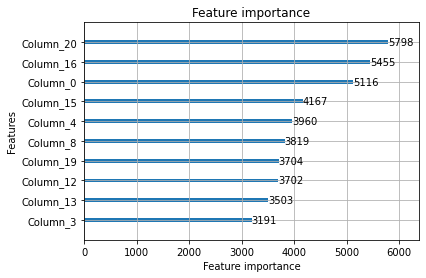

In [220]:
### 변수중요도 파악 ###
import lightgbm as lgb
lgb.plot_importance(lgbm_clf, max_num_features = 10)


In [221]:
# 어떻게 하지?? # 20, 16, 0, 15, 4, 8, 9  # 직전년도 매출액영업이익률, 직전년도매출액증가율, 종업원수, 2년전 매출액증가율, 직전년도 매출액, 직전년도 영업이익 순임

In [228]:
def make_feature_im_df():
    feature_df = pd.DataFrame({"col":lgbm_clf.feature_name_, "name":X.columns, 'importance':lgbm_clf.feature_importances_})
    feature_df = feature_df.sort_values("importance", ascending = False)
    return feature_df

In [229]:
feature_im_df = make_feature_im_df()

In [233]:
feature_im_df.head(30)

,col,name,importance
20,Column_20,매출액영업이익율(2021),5798
16,Column_16,매출액증가율(2021),5455
0,Column_0,종업원 수,5116
15,Column_15,매출액증가율(2020),4167
4,Column_4,매출액(2021),3960
8,Column_8,영업이익(2021),3819
19,Column_19,매출액영업이익율(2020),3704
12,Column_12,미처분이익잉여금(2021),3702
13,Column_13,매출액증가율(2018),3503
3,Column_3,매출액(2020),3191
